In [2]:
# imports
%matplotlib notebook
import matplotlib.pyplot as plt
#from camera import take_picture
import numpy as np
import os
import random

In [3]:
# download dlib models
from dlib_models import download_model, download_predictor, load_dlib_models
download_model()
download_predictor()
from dlib_models import models

	from http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2
	to: c:\program files\anaconda3\lib\site-packages\dlibmodels-0.0-py3.6.egg\dlib_models
Downloaded and decompressed: c:\program files\anaconda3\lib\site-packages\dlibmodels-0.0-py3.6.egg\dlib_models\dlib_face_recognition_resnet_model_v1.dat
	from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
	to: c:\program files\anaconda3\lib\site-packages\dlibmodels-0.0-py3.6.egg\dlib_models
Downloaded and decompressed: c:\program files\anaconda3\lib\site-packages\dlibmodels-0.0-py3.6.egg\dlib_models\shape_predictor_68_face_landmarks.dat


In [4]:
load_dlib_models()
face_detect = models["face detect"]
shape_predictor = models["shape predict"]

In [5]:
def readfile_emotion(filename):
    with open(filename, mode='r') as file:
        return int(float(file.read().split()[0]))

In [10]:
import matplotlib.image as mpimg

def import_cohn_kanade_full(dataset="database\Cohn-Kanade", extension_images=".png", extension_emotions=".txt", cutoff=0.125):
    images = []
    emotions = []
    
    path_images = os.path.join(dataset, "cohn-kanade-images")
    path_emotions = os.path.join(dataset, "Emotion")
    # for every subject
    subjects = os.listdir(path_images)
    random.shuffle(subjects)
    for di in subjects:
        dire_images = os.path.join(path_images, di)
        dire_emotions = os.path.join(path_emotions, di)
        if os.path.isdir(dire_images) and os.path.isdir(dire_emotions):
            # for every sequence
            for subdi in os.listdir(dire_images):
                subdire_images = os.path.join(dire_images, subdi)
                subdire_emotions = os.path.join(dire_emotions, subdi)
                if os.path.isdir(subdire_images) and os.path.isdir(subdire_emotions):
                    # find the first and only emotion file
                    emotion = None
                    for fi in os.listdir(subdire_emotions):
                        if fi.endswith(extension_emotions) and not fi.startswith("._"):
                            path = os.path.join(subdire_emotions, fi)
                            emotion = readfile_emotion(path)
                            break
                    # for every neutral image
                    valid_images = [fi for fi in os.listdir(subdire_images) if fi.endswith(extension_images) and not fi.startswith("._")]
                    split = int(len(valid_images)*cutoff)
                    for fi_image in valid_images[:split]:
                        path_image = os.path.join(subdire_images, fi_image)
                        image = mpimg.imread(path_image)
                        # add to return array
                        images.append(image)
                        emotions.append(0)
                    if emotion is None:
                        continue
                    # for every emotional image
                    for fi_image in valid_images[split:]:
                        path_image = os.path.join(subdire_images, fi_image)
                        image = mpimg.imread(path_image)
                        # add to return array
                        images.append(image)
                        emotions.append(emotion)
    return [(255*image).astype('uint8') for image in images], emotions

In [11]:
imgs, y = import_cohn_kanade_full()

In [13]:
labels = ["neutral", "angry", "contempt", "disgusted", "afraid", "happy", "sad", "surprised"]
new_labels = ["sad", "neutral", "happy"]
transform = [1, 0, 1, 0, 0, 2, 0, 2]

y = np.array([transform[i] for i in y])

In [7]:
from dlib import get_face_chip

detects = [face_detect(img) for img in imgs]
chips = [get_face_chip(img, shape_predictor(img, detect[0])) for img, detect in zip(imgs, detects) if len(detect) >= 1]

In [14]:
from dlib import get_face_chip

chips = [get_face_chip(img, shape_predictor(img, face_detect(img)[0])) for img in imgs]

In [80]:
from dlib import get_face_chips
from dlib import full_object_detections

detections = face_detect(pic)
full_dets = full_object_detections([shape_predictor(pic, detection) for detection in detections])
chips = get_face_chips(pic, full_dets)

<IPython.core.display.Javascript object>


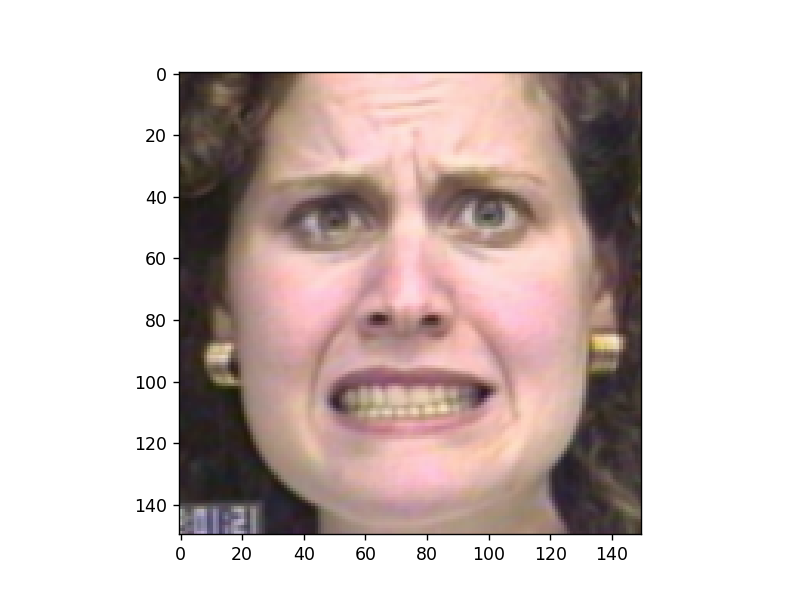

In [15]:
fig, ax = plt.subplots()

for chip in chips:
    ax.clear()
    ax.imshow(chip)
    fig.canvas.draw()

In [17]:
x = np.array(chips)

In [21]:
import sklearn

N = x.shape[0]
split = round(N*0.9)

xtrain = x[:split]
ytrain = y[:split]
xtest = x[split:]
ytest = y[split:]

# shuffle after to get new people in test
xtrain, ytrain = sklearn.utils.shuffle(xtrain, ytrain)
xtest, ytest = sklearn.utils.shuffle(xtest, ytest)

<IPython.core.display.Javascript object>


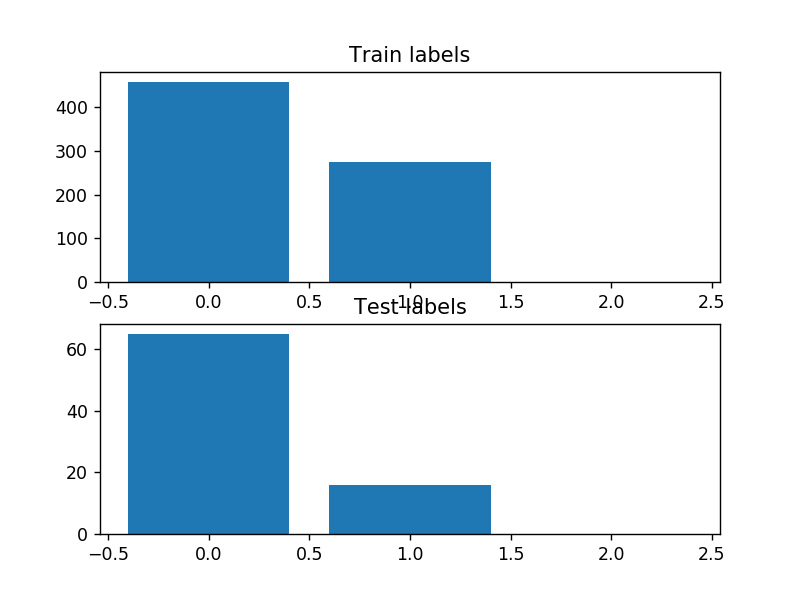

In [23]:
from collections import Counter

fig, ax = plt.subplots(2)

hist_train = [0]*3
hist_test = [0]*3
for i, c in Counter(ytrain).items():
    hist_train[i] = c
for i, c in Counter(ytest).items():
    hist_test[i] = c
ax[0].bar(range(3), hist_train)
ax[1].bar(range(3), hist_test)
ax[0].set_title("Train labels");
ax[1].set_title("Test labels");